**Environment Setup**

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip3 install -q pydicom

     |████████████████████████████████| 61kB 2.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=05492381b5aa0e70fa76feb689aa9de259989d9a7274930e9ad2f708127e1d54
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
     |████████████████████████████████| 35.5MB 119kB/s 


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "shreek" # username from the json file
os.environ['KAGGLE_KEY'] = "2fcd841dfedbc878a12d5c32bb7f4e6c" # key from the json file
!kaggle competitions download --force -c rsna-pneumonia-detection-challenge

100% 3.65G/3.66G [00:46<00:00, 56.0MB/s]
100% 3.66G/3.66G [00:46<00:00, 84.3MB/s]


In [ ]:
from google.colab import files
import urllib.request
import glob
import sys
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import csv
from google.colab import drive
from google.colab import files
import shutil
from scipy.ndimage.interpolation import zoom
import glob
import sys
import numpy as np
import scipy.misc

In [ ]:
#Extracting the dataset files
path_to_zip_file='/content/rsna-pneumonia-detection-challenge.zip'
directory_to_extract_to='/content/rsna-pneumonia-detection-challenge'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
!pip3 install -q pydicom    
import pydicom as dicom   
import cv2  

**Converting dicom to png images**

In [ ]:
png_folder_path = "/content/rsna-pneumonia-detection-challenge/stage_2_png_train_images"
if not os.path.exists(png_folder_path):
    os.makedirs(png_folder_path)

In [ ]:
TRAIN_DIR='/content/rsna-pneumonia-detection-challenge/stage_2_train_images'
# Specify the .dcm folder path
folder_path = TRAIN_DIR

images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(png_folder_path, image), pixel_array_numpy)

Visualising the png image

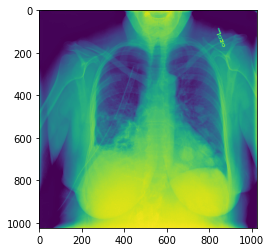

In [ ]:
path='/content/rsna-pneumonia-detection-challenge/stage_2_png_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.png'
image = mpimg.imread(path)
plt.imshow(image)
plt.show()

Loading the labels dataset

In [ ]:
train_labels=pd.read_csv('/content/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
detailed_class_info=pd.read_csv('/content/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [ ]:
train_class_info=pd.merge(train_labels,detailed_class_info,on='patientId')
train_class_info.drop_duplicates(inplace=True)
train_class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

As the distribution of positive and negative cases is not equal,we drop the 'No Lung Opacity / Not Normal' class from the dataset

In [ ]:
Annotations=train_class_info[train_class_info['class']!='No Lung Opacity / Not Normal']
Annotations['class'].value_counts()

Lung Opacity    9555
Normal          8851
Name: class, dtype: int64

Preparation of Annotations for images

In [ ]:
Annotations["patientId"] = [os.path.join(png_folder_path, "{}.png".format(_)) for _ in Annotations.patientId]
Annotations['xmax']=Annotations['x'] + Annotations['width']
Annotations['ymax']=Annotations['y'] + Annotations['height']
Annotations.fillna(0,inplace=True)
positives=Annotations[Annotations['class']=='Lung Opacity']
positives.to_csv('/content/rsna-pneumonia-detection-challenge/Annotations.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
data=pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])
with open(os.path.join('/content/rsna-pneumonia-detection-challenge/Annotations.csv'), mode='r') as infile:   
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        filename = rows[1]
        xmin     = rows[2]
        xmax     = rows[8] 
        ymin     = rows[3]
        ymax     = rows[9]
        cls_name = rows[7] 
        data = data.append({'fileName': filename, 'xmin': xmin, 'ymin':ymin,'xmax':xmax,'ymax':ymax,'class':cls_name}, ignore_index=True)

In [ ]:
data["xmin"] = data.xmin.astype("float").astype("int32")
data["xmax"] = data.xmax.astype("float").astype("int32")
data["ymin"] = data.ymin.astype("float").astype("int32")
data["ymax"] = data.ymax.astype("float").astype("int32")
data.to_csv('/content/rsna-pneumonia-detection-challenge/annotations.csv', index=False, header=False)

classes = ['Normal','Lung Opacity']
with open('/content/rsna-pneumonia-detection-challenge/classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')  

**Model Building**

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6014, done.
remote: Total 6014 (delta 0), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6014/6014), 14.83 MiB | 31.78 MiB/s, done.
Resolving deltas: 100% (4056/4056), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=171495 sha256=5bf2a9f585d795e7017df6f39b6b811515ba084be8dff653e15f2bc2bb31316b
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=4cc434af203d3b3a2e159fb13bfbd07235b1042cdc173bea19bcc3f6f1a9eb0b
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_

In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
drive.mount('/content/gdrive')
DRIVE_MODEL = '/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
shutil.copy(DRIVE_MODEL, './snapshots/resnet50_csv_10.h5')


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Mounted at /content/gdrive
Downloaded pretrained model to ./snapshots/_pretrained_model.h5


**RetinaNet model**

In [ ]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --image-min-side 256 --image-max-side 256 --batch-size 8 --steps 500 --epochs 10 csv /content/rsna-pneumonia-detection-challenge/annotations.csv /content/rsna-pneumonia-detection-challenge/classes.csv

2020-09-16 05:01:46.343097: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-09-16 05:01:48.734074: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 05:01:48.737469: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-16 05:01:48.737516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4b26d378c9f9): /proc/driver/nvidia/version does not exist
2020-09-16 05:01:48.744621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-09-16 05:01:48.744939: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2d9aa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
20

In [ ]:
from keras_retinanet.models import load_model 
retinanet = load_model(os.path.join("./snapshots/resnet50_csv_01.h5"), backbone_name="resnet50")

**Model Predictions**

In [ ]:
# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [60]:
# Preprocessing function 
def preprocess_input(x):
    x = x.astype("float32")
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.680
    return x

In [138]:
# load label to names mapping for visualization purposes
import matplotlib.patches as patches
CLASSES_FILE='/content/rsna-pneumonia-detection-challenge/classes.csv'
labels_to_names = pd.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

def img_inference(img_path):
    dcm = dicom.read_file(img_path)
    arr = dcm.pixel_array
    # Make 3-channel image
    img = np.zeros((arr.shape[0], arr.shape[1], 3))
    for channel in range(img.shape[-1]):
        img[..., channel] = arr 
    # Resize 
    # Change image size if necessary!
    scale_factor = 256. / img.shape[0]
    img = zoom(img, [scale_factor, scale_factor, 1], order=1, prefilter=False)
    # Preprocess with ImageNet mean subtraction
    img = preprocess_input(img) 
    prediction = retinanet.predict_on_batch(np.expand_dims(img, axis=0))
    
    figure, ax = plt.subplots(1)
    x=int(np.round(prediction[0][0][0][0] * 250))
    y=int(np.round(prediction[0][0][0][1] * 250))
    w=int(np.round(prediction[0][0][0][2] * 250))
    h=int(np.round(prediction[0][0][0][3] * 250))
    print(prediction[0][0][0][:5])
    rect = patches.Rectangle((x,y),w,h, edgecolor='r', facecolor="none")
    ax.imshow(img)
    ax.add_patch(rect) 

    
    with open(os.path.join('/content/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:   
     reader = csv.reader(infile)
     next(reader, None)
     for rows in reader:
      filename='/content/rsna-pneumonia-detection-challenge/stage_2_train_images/'+rows[0] + '.dcm'
      
      if filename==img_path:
        print(rows)
        x1= int(np.round(int(float(rows[1])) * 250/1024))
        y1= int(np.round(int(float(rows[2])) * 250/1024))
        w1= int(np.round(int(float(rows[3])) * 250/1024))
        h1= int(np.round(int(float(rows[4])) * 250/1024))
        rect1= patches.Rectangle((x1,y1),w1,h1, edgecolor='g', facecolor="none")
        ax.add_patch(rect1) 
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.77905995  0.36060876 -0.17426434 -0.16086827]
['000db696-cf54-4385-b10b-6b16fbb3f985', '316.0', '318.0', '170.0', '478.0', '1']
['000db696-cf54-4385-b10b-6b16fbb3f985', '660.0', '375.0', '146.0', '402.0', '1']


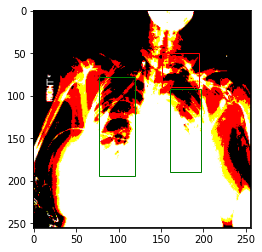

In [139]:
img_infer='/content/rsna-pneumonia-detection-challenge/stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
img_inference(img_infer)

In [ ]:
test_dicoms_dir='/content/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_dicoms = glob.glob(os.path.join(test_dicoms_dir, "*.dcm"))
test_patient_ids = [_.split("/")[-1].split(".")[0] for _ in test_dicoms]
test_predictions = [] 
for i, dcm_file in enumerate(test_dicoms): 
    sys.stdout.write("Predicting images: {}/{} ...\r".format(i+1, len(test_dicoms)))
    sys.stdout.flush() 
    # Load DICOM and extract pixel array 
    dcm = dicom.read_file(dcm_file)
    arr = dcm.pixel_array
    # Make 3-channel image
    img = np.zeros((arr.shape[0], arr.shape[1], 3))
    for channel in range(img.shape[-1]):
        img[..., channel] = arr 
    # Resize 
    # Change image size if necessary!
    scale_factor = 256. / img.shape[0]
    img = zoom(img, [scale_factor, scale_factor, 1], order=1, prefilter=False)
    # Preprocess with ImageNet mean subtraction
    img = preprocess_input(img) 
    prediction = retinanet.predict_on_batch(np.expand_dims(img, axis=0))
    test_predictions.append(prediction)  

Extract predictions

In [ ]:
test_pred_df = pd.DataFrame() 
for i, pred in enumerate(test_predictions):
    # Take top 5 
    # Should already be sorted in descending order by score
    bboxes = pred[0][0][0][:5]
    scores = pred[1][0][0][0]
    # -1 will be predicted if nothing is detected
    detected = np.sum(scores) > -1 
    if np.sum(detected) == 0: 
        continue
    else:
        bboxes = bboxes[detected]
        bboxes = [box / scale_factor for box in bboxes]
        scores = scores[detected]
    individual_pred_df = pd.DataFrame() 
    for j, each_box in enumerate(bboxes): 
        # RetinaNet output is [x1, y1, x2, y2] 
        tmp_df = pd.DataFrame({"patientId": [test_patient_ids[i]], 
                               "x": [each_box[0]],  
                               "y": [each_box[1]], 
                               "w": [each_box[2]-each_box[0]],
                               "h": [each_box[3]-each_box[1]],
                               "score": [scores[j]]})
        individual_pred_df = individual_pred_df.append(tmp_df) 
    test_pred_df = test_pred_df.append(individual_pred_df) 


In [ ]:
test_pred_df.head()

Submission csv

In [ ]:
threshold = 0

list_of_pids = [] 
list_of_preds = [] 
for pid in np.unique(test_pred_df.patientId): 
    tmp_df = test_pred_df[test_pred_df.patientId == pid]
    tmp_df = tmp_df[tmp_df.score >= threshold]
    # Skip if empty
    if len(tmp_df) == 0:
        continue
    predictionString = " ".join(["{} {} {} {} {}".format(row.score, row.x, row.y, row.w, row.h) for rownum, row in tmp_df.iterrows()])
    list_of_preds.append(predictionString)
    list_of_pids.append(pid) 

positives = pd.DataFrame({"patientId": list_of_pids, 
                          "PredictionString": list_of_preds}) 

negatives = pd.DataFrame({"patientId": list(set(test_patient_ids) - set(list_of_pids)), 
                          "PredictionString": [""] * (len(test_patient_ids)-len(list_of_pids))})

submission = positives.append(negatives) 

In [ ]:
submission.iloc[0][1]